In [32]:
# import os
import os.path
os.environ['USE_PYGEOS'] = '0'
import xarray as xr
import numpy as np
import pandas as pd
import fiona
import glob
import dask_geopandas
import geopandas as gpd
import time
from copy import deepcopy
from functools import reduce

import aggfly
import netCDF4

import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar

from aggfly import regions
from aggfly import dataset, regions, grid_weights
from aggfly.aggregate import TemporalAggregator, SpatialAggregator
# from aggfly.aggregate import TemporalAggregator, SpatialAggregator

ProgressBar().register()
# client = Client(n_workers=2)

project_dir = '/user/gb2884/aggfly/notebooks/giovanni_example'

   OBJECTID                    CNTRY_NAME CNTRY_CODE  BPL_CODE  \
0         1                       Algeria        012   13010.0   
1         2                        Angola        024   12010.0   
2         3  In dispute South Sudan/Sudan       9999   99999.0   
3         4                         Benin        204   15010.0   
4         5                      Botswana        072   14010.0   

                                            geometry  
0  MULTIPOLYGON (((-2.05592 35.07370, -2.05675 35...  
1  MULTIPOLYGON (((12.79760 -4.41685, 12.79875 -4...  
2  POLYGON ((28.08408 9.34722, 28.03889 9.34722, ...  
3  MULTIPOLYGON (((1.93753 6.30122, 1.93422 6.299...  
4  POLYGON ((25.16312 -17.77816, 25.16383 -17.778...  


<Axes: >

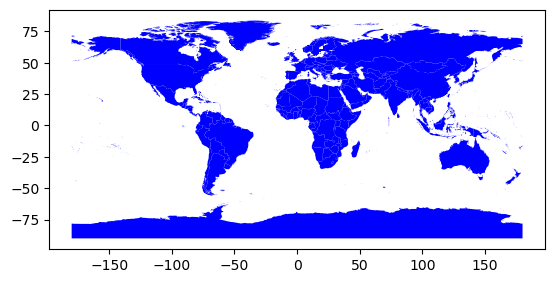

In [33]:
gdf = gpd.read_file("/user/gb2884/Macro_Enviro_Dev/1_Data/world_example/IPUMSI_world_release2020/world_countries_2020.shp")
print(gdf.head())
#gdf.plot(color='blue', legend=True)



In [34]:
import os
import os.path

# Years to aggregate
years = np.arange(1951,2020)
years = years[years != 1959]

georegions = regions.from_path("/user/gb2884/aggfly/notebooks/giovanni_example/usa_simple_noHI.shp",regionid='geometry')
#georegions = regions.from_path('/user/gb2884/Macro_Enviro_Dev/1_Data/world_example/IPUMSI_world_release2020/world_countries_2020.shp',regionid='OBJECTID')
georegions.shp["GEOID"]=range(50)


#RI = georegions.shp[georegions.shp['GEOID'] == 39]
RI = georegions.shp[(georegions.shp['GEOID'] == 2) | (georegions.shp['GEOID'] == 39)]

#RI = georegions.shp.loc[georegions.shp.GEOID=='1']
#RI = georegions.shp.loc[georegions.shp.STATEFP=='44']
#RI = georegions.shp.loc[georegions.shp.CNTRY_CODE == '012']

#georegions = georegions.sel(RI.GEOID)
georegions.shp = georegions.shp[georegions.shp['GEOID'].isin(RI['GEOID'])]

print(georegions.shp.columns)

Index(['geometry', 'GEOID'], dtype='object')


In [35]:
print(RI)
print(georegions.shp.shape)
georegions
print(georegions.shp)

                                             geometry  GEOID
2   POLYGON ((-110.97208 31.33012, -111.04955 31.3...      2
39  MULTIPOLYGON (((-80.41515 32.49290, -80.44278 ...     39
(2, 2)
                                             geometry  GEOID
2   POLYGON ((-110.97208 31.33012, -111.04955 31.3...      2
39  MULTIPOLYGON (((-80.41515 32.49290, -80.44278 ...     39


<Axes: >

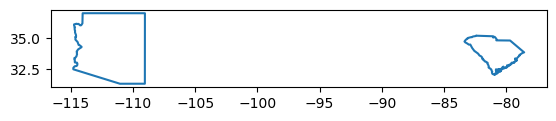

In [36]:
georegions.shp.boundary.plot()

In [37]:
def preprocess_era5l(array):
    # Function for cleaning the era5l data.
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):   
        # Reformat longitude
        array.coords['longitude'] = (array.coords['longitude'] + 180) % 360 - 180
        array = array.sortby(array.longitude)
        # Kelvin -> Celsius
        array = array - 273.15
    return array

# Open example dataset to construct weights.
clim = dataset.from_path(
    #f"/Users\gb2884/The Lab Dropbox/Giovanni Brocca/Macro_Enviro_Dev/1_Data/world_example/era_june_2000_2tm.nc", 
    #f"/Users/gb2884/The Lab Dropbox/Giovanni Brocca/Macro_Enviro_Dev/1_Data/IPUMS_1level_example/era_1st_June_2000_tm.nc",
    f"/user/gb2884/Macro_Enviro_Dev/1_Data/IPUMS_1level_example/era_2000_2tm.nc",
    var = 't2m',
    engine = 'netcdf4',
    name='era5',
    clip_geom=georegions,
    preprocess = preprocess_era5l)

clim.rechunk(chunks=-1)

# Calculate area and pop layer weights.
weights = grid_weights.from_objects(
    clim,
    georegions,
    wtype=None,
    simplify=0.001,
    project_dir=project_dir)


#clim.clip_data_to_georegions_extent(georegions)

print("Loading weights")
w = weights.weights()
nzw_ind = np.isin(clim.grid.index, w.cell_id).nonzero()
print(w) 
#print(nzw_ind)
#print(clim.grid.index)
#print(w.cell_id)

/user/gb2884/aggfly/notebooks/giovanni_example/tmp/GridWeights/mod-fea56a57398ee80
Creating new cache (mod-fea56a57398ee80) in /user/gb2884/aggfly/notebooks/giovanni_example/tmp/GridWeights/mod-fea56a57398ee80
Loading weights
Cache file /user/gb2884/aggfly/notebooks/giovanni_example/tmp/GridWeights/mod-fea56a57398ee80/c2d709b1733d84f.feather not found.
{'func': 'weights', 'raster_weights': None}
Searching for border cells...
Negative buffer
[########################################] | 100% Completed | 103.08 ms
[########################################] | 100% Completed | 105.72 ms
[########################################] | 100% Completed | 105.62 ms
[########################################] | 100% Completed | 103.74 ms
[########################################] | 100% Completed | 104.97 ms
[########################################] | 100% Completed | 112.73 ms
[########################################] | 100% Completed | 409.30 ms
[########################################] | 100% C

In [38]:
print("Scheduling aggregation")
dailies = [
    TemporalAggregator('avg', 'time.date')
]
monthly = TemporalAggregator('sum', 'time.month')

Scheduling aggregation


In [39]:
out = pd.DataFrame()
#for year in years:
#    print(year)
#    start = time.time()
year = 2000

print('Loading climate data')
clim = dataset.from_path(
    #f"/Users\gb2884/The Lab Dropbox/Giovanni Brocca/Macro_Enviro_Dev/1_Data/world_example/era_june_2000_2tm.nc", 
    #f"/Users/gb2884/The Lab Dropbox/Giovanni Brocca/Macro_Enviro_Dev/1_Data/IPUMS_1level_example/era_1st_June_2000_tm.nc",
    f"/user/gb2884/Macro_Enviro_Dev/1_Data/IPUMS_1level_example/era_2000_2tm.nc",
    var = 't2m',
    engine = 'netcdf4',
    name='era5',
    clip_geom=georegions,
    preprocess = preprocess_era5l)
#clim.update(clim.da.persist())

clim.rechunk(chunks=-1)



print('Aggregating')
day_ds = [x.map_execute(clim, nzw_ind) for x in dailies]
month_ds = [monthly.map_execute(x, nzw_ind) for x in day_ds]

Loading climate data
Aggregating


In [40]:
clim.da
#clim.da.sel(time=clim.da.time[0]).plot()

<xarray.DataArray 'array-c9bdc18c3ea07aabc2a7ff3062690939' (latitude: 24,
                                                            longitude: 146,
                                                            time: 8616)>
dask.array<rechunk-merge, shape=(24, 146, 8616), dtype=float32, chunksize=(24, 146, 8616), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -114.8 -114.5 -114.2 ... -79.0 -78.75 -78.5
  * latitude   (latitude) float32 37.0 36.75 36.5 36.25 ... 31.75 31.5 31.25
  * time       (time) datetime64[ns] 2000-01-01 ... 2000-12-30T23:00:00

In [41]:
names = ['avg']
df = SpatialAggregator(month_ds, w, weights.grid, names=names).compute()
    
# Clean output dataset and append
df = df.reset_index().rename(columns={'time':'month'})
df['year'] = year
df = df[['region_id', 'year', 'month'] + names]
df = georegions.shp[['GEOID']].merge(df, left_index=True, right_on='region_id')

out = pd.concat([out, df])

[########################################] | 100% Completed | 3.49 ss
[########################################] | 100% Completed | 3.59 s
[########################################] | 100% Completed | 3.60 s
[########################################] | 100% Completed | 102.34 ms
[########################################] | 100% Completed | 204.27 ms
[########################################] | 100% Completed | 209.82 ms


In [ ]:
#out.reset_index().to_feather("/home3/dth2133/data/clim_data_requests/maya/temp_data_maya.feather")

<Axes: >

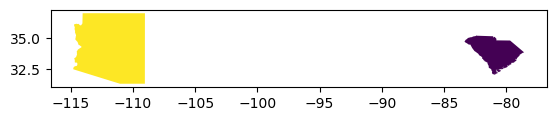

In [42]:
slc = out.loc[out.year==2000].groupby('GEOID').mean()
georegions.shp.merge(slc, right_index=True, left_on='GEOID').plot(column='avg')

In [43]:
print(georegions.shp.columns)
print(slc["avg"])

Index(['geometry', 'GEOID'], dtype='object')
GEOID
2     507.257259
39    500.835142
Name: avg, dtype: float64
